In [ ]:
!git clone https://github.com/kelvis24/cell-counting.git

Cloning into 'cell-counting'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!unzip /content/IDCIAv2.zip

In [ ]:
!unzip /content/test_images.zip

In [ ]:

import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split




In [ ]:
class IDCIAv2(Dataset):
    def __init__(self, image_files, csv_files, transform=None):
        self.image_files = image_files
        self.csv_files = csv_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        csv_path = self.csv_files[idx]


        image = imread(image_path)
        # Read the csv file and get the number of cells in the image
        ground_truth = pd.read_csv(csv_path)
        cell_count = ground_truth.shape[0]

        if self.transform:
            image = self.transform(image)

        return image, cell_count

# Data preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [ ]:
import csv
import random

# Load image and CSV file paths
image_dir = '/content/IDCIAv2/images'
csv_dir = '/content/IDCIAv2/ground_truth'

count_dict = {}
image_files = [file for file in os.listdir(image_dir) if file.endswith('.tiff')]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)

    csv_file_path = os.path.join(csv_dir, f"{os.path.splitext(image_file)[0]}.csv")

    # Get the cell_count of each file
    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        row_count = sum(1 for row in csv_reader) - 1
        count_dict[image_file] = row_count

# Sort count_dict by counts in ascending order
sorted_counts = sorted(count_dict.items(), key=lambda x: x[1], reverse = False)
sorted_images = [ image [0] for image in sorted_counts]
print (sorted_counts)
print (sorted_images)

# Assign weights based on the rank of counts
weights = {}
for rank, (image_file, _) in enumerate(sorted_counts):
    weights[image_file] = rank + 1  # Adding 1 to avoid zero weight
    #print(weights)
total_weight = sum(weights.values())

# Assign the probability based on the normalized weight to the image files
probabilities = [weight / total_weight for weight in weights.values()]
print (probabilities)

# Selecting the number_of_images
number_of_images = 150
total_file_indicies = list (range(len(sorted_counts)))
chosen = []
Add_element = True
final_image_list = []

i = 0
while (Add_element):
  i = i + 1
  chosen_index = random.choices(total_file_indicies, probabilities, k = 1)[0]
  if chosen_index not in chosen:
    chosen.append(chosen_index)
    final_image_list.append(sorted_images[chosen_index])
  if len(final_image_list) == number_of_images:
    Add_element = False

print("Steps taken for selecting images: ", i)
print("total number of files chosen" , len (final_image_list))
print("Final Image List:", final_image_list)

[('220909_GFP-AHPC_D_MAP2ab_F4_DAPI_ND1_20x.tiff', 0), ('220815_GFP-AHPC_D_MAP2ab_F4_DAPI_ND1_20x.tiff', 8), ('220912_GFP-AHPC_B_Nestin_F8_DAPI_ND1_20x.tiff', 9), ('220815_GFP-AHPC_D_MAP2ab_F6_DAPI_ND1_20x.tiff', 10), ('220909_GFP-AHPC_B_Ki67_F3_DAPI_ND1_20x.tiff', 10), ('220912_GFP-AHPC_B_Nestin_F9_DAPI_ND1_20x.tiff', 10), ('220912_GFP-AHPC_C_Map2AB_F5_DAPI_ND1_20x.tiff', 11), ('220912_GFP-AHPC_C_Map2AB_F7_DAPI_ND1_20x.tiff', 12), ('220815_GFP-AHPC_A_TuJ1_F3_DAPI_ND1_20x.tiff', 12), ('220815_GFP-AHPC_D_MAP2ab_F10_DAPI_ND1_20x.tiff', 12), ('220815_GFP-AHPC_D_MAP2ab_F8_DAPI_ND1_20x.tiff', 13), ('220815_GFP-AHPC_C_Ki67_F7_DAPI_ND1_20x.tiff', 14), ('220815_GFP-AHPC_C_Ki67_F8_DAPI_ND1_20x.tiff', 14), ('220815_GFP-AHPC_C_TuJ1_F7_DAPI_ND1_20x.tiff', 15), ('220909_GFP-AHPC_C_Nestin_F8_DAPI_ND1_20x.tiff', 15), ('220815_GFP-AHPC_C_Ki67_F4_DAPI_ND1_20x.tiff', 16), ('220815_GFP-AHPC_A_Ki67_F1_DAPI_ND1_20x.tiff', 16), ('220912_GFP-AHPC_C_Map2AB_F2_DAPI_ND1_20x.tiff', 17), ('220815_GFP-AHPC_C_Ki67_

In [ ]:
# import os
# import shutil
# import random
# from PIL import Image, ImageFilter, ImageOps
# import numpy as np

# def augment_image(image_path, output_path):
#     """Apply random augmentations to an image and save it."""
#     augmentations = []

#     with Image.open(image_path) as img:
#         # Randomly choose the augmentations to apply
#         if random.choice([True, False]):
#             img = img.transpose(Image.FLIP_LEFT_RIGHT)
#             augmentations.append("flipped")
#         if random.choice([True, False]):
#             angle = random.choice([90, 180, 270])
#             img = img.rotate(angle)
#             augmentations.append(f"rotated by {angle} degrees")
#         if random.choice([True, False]):
#             img = img.filter(ImageFilter.BLUR)
#             augmentations.append("blurred")
#         if random.choice([True, False]):
#             # Adding random noise
#             np_img = np.array(img)
#             noise = np.random.normal(0, 25, np_img.shape)
#             np_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
#             img = Image.fromarray(np_img)
#             augmentations.append("noise added")

#         img.save(output_path)

#     return augmentations

# def augment_image_list(image_list, output_folder, multiplier):
#     """Create a new folder with both original and augmented images."""
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder, exist_ok=True)

#     print(f"Found {len(image_list)} original images.")

#     total_augmented = 0

#     for i, image_path in enumerate(image_list):
#         # Copy the original image to the output folder
#         image_path = f"/content/IDCIAv2/images/{image_path}"
#         original_file_name = os.path.basename(image_path)
#         original_output_path = os.path.join(output_folder, original_file_name)
#         shutil.copy2(image_path, original_output_path)

#         # Generate augmented images
#         for m in range(multiplier):
#             augmented_file_name = f"{i}_{m}_{original_file_name}"
#             augmented_output_path = os.path.join(output_folder, augmented_file_name)
#             augmentations = augment_image(image_path, augmented_output_path)
#             print(f"Image {original_file_name} augmented with: {', '.join(augmentations) if augmentations else 'No augmentations'}")
#             total_augmented += 1

#     print(f"Total images in the augmented folder: {len(image_list) + total_augmented}")

In [ ]:
import os
import shutil
import random
from PIL import Image, ImageFilter, ImageOps
import numpy as np

def augment_image(image_path, output_path):
    """Apply at least one random augmentation to an image and save it."""
    augmentations = []

    with Image.open(image_path) as img:
        applied = False
        while not applied:
            # Randomly choose the augmentations to apply
            if random.choice([True, False]):
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                augmentations.append("flipped")
                applied = True
            if random.choice([True, False]):
                angle = random.choice([180])
                img = img.rotate(angle)
                augmentations.append(f"rotated by {angle} degrees")
                applied = True
            if random.choice([True, False]):
                img = img.filter(ImageFilter.BLUR)
                augmentations.append("blurred")
                applied = True
            if random.choice([True, False]):
                # Adding random noise
                np_img = np.array(img)
                noise = np.random.normal(0, 25, np_img.shape)
                np_img = np.clip(np_img + noise, 0, 255).astype(np.uint8)
                img = Image.fromarray(np_img)
                augmentations.append("noise added")
                applied = True

        img.save(output_path)

    return augmentations

def augment_image_list(image_list, output_folder, multiplier):
    """Create a new folder with both original and augmented images."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder, exist_ok=True)

    print(f"Found {len(image_list)} original images.")

    total_augmented = 0

    for i, image_path in enumerate(image_list):
        # Copy the original image to the output folder
        image_path = f"/content/IDCIAv2/images/{image_path}"
        original_file_name = os.path.basename(image_path)
        original_output_path = os.path.join(output_folder, original_file_name)
        shutil.copy2(image_path, original_output_path)

        # Generate augmented images
        for m in range(multiplier):
            augmented_file_name = f"{i}_{m}_{original_file_name}"
            augmented_output_path = os.path.join(output_folder, augmented_file_name)
            augmentations = augment_image(image_path, augmented_output_path)
            print(f"Image {original_file_name} augmented with: {', '.join(augmentations) if augmentations else 'No augmentations'}")
            total_augmented += 1

    print(f"Total images in the augmented folder: {len(image_list) + total_augmented}")


In [ ]:
augment_image_list(final_image_list, "/content/new_augmented_images", 3)

In [ ]:

new_augmented_folder = "/content/new_augmented_images"
ground_truth_folder = "/content/IDCIAv2/ground_truth"

# List all image files in the new_augmented_folder
new_final_image_list = [filename for filename in os.listdir(new_augmented_folder) if filename.endswith('.tiff')]
new_final_image_list = [os.path.join(new_augmented_folder, filename) for filename in new_final_image_list]



# Create a corresponding list of CSV files
new_final_csv_files = []  # Initialize an empty list to store the CSV file paths

for filename in new_final_image_list:
    # Remove the directory path from the filename
    filename = filename.split('/')[-1]

    # Check if the filename indicates it's an augmented image
    # if filename.count('_') >= 2:
    if len(filename.split('_')[0]) < 5:

        # This is an augmented image, extract the original image name
        original_image_name = '_'.join(filename.split('_')[2:])
    else:
        # This is an original image, use the filename as is
        original_image_name = filename

    # Debugging prints
    print("filename:", filename)
    print("original_image_name:", original_image_name)

    # Replace the file extension from '.tiff' to '.csv'
    csv_filename = original_image_name.replace('.tiff', '.csv')

    # Construct the full path for the CSV file
    full_csv_path = os.path.join(ground_truth_folder, csv_filename)

    # Add the full path to the list
    new_final_csv_files.append(full_csv_path)

# Print the results
print(f"Found {len(new_final_csv_files)} corresponding CSV files.")
print(new_final_csv_files)


# Split data into train, validation, and test sets
train_files, test_files, train_csv, test_csv = train_test_split(new_final_image_list, new_final_csv_files, test_size=0.3, random_state=42)
val_files, test_files, val_csv, test_csv = train_test_split(test_files, test_csv, test_size=0.5, random_state=42)

# Create instances of the dataset for training, validation, and testing
train_dataset = IDCIAv2(image_files=train_files, csv_files=train_csv, transform=transform)
val_dataset = IDCIAv2(image_files=val_files, csv_files=val_csv, transform=transform)
test_dataset = IDCIAv2(image_files=test_files, csv_files=test_csv, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Statistics of datasets
train_cell_counts = [sample[1] for sample in train_dataset]
val_cell_counts = [sample[1] for sample in val_dataset]
test_cell_counts = [sample[1] for sample in test_dataset]

# Calculate statistics
num_train_images = len(train_dataset)
num_val_images = len(val_dataset)
num_test_images = len(test_dataset)

mean_train_cells_per_image = np.mean(train_cell_counts)
std_train_cells_per_image = np.std(train_cell_counts)

mean_val_cells_per_image = np.mean(val_cell_counts)
std_val_cells_per_image = np.std(val_cell_counts)

mean_test_cells_per_image = np.mean(test_cell_counts)
std_test_cells_per_image = np.std(test_cell_counts)

stats = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'Number of Images': [num_train_images, num_val_images, num_test_images],
    'Mean Cell Counts': [np.mean(train_cell_counts), np.mean(val_cell_counts), np.mean(test_cell_counts)],
    'Std Deviation Cell Counts': [np.std(train_cell_counts), np.std(val_cell_counts), np.std(test_cell_counts)]

}

# Create a DataFrame
df = pd.DataFrame(stats)

# Display the table
print("Statistics of Datasets:")
print(df)


Statistics of Datasets:
      Dataset  Number of Images  Mean Cell Counts  Std Deviation Cell Counts
0    Training               420        245.295238                 209.870637
1  Validation                90        267.222222                 232.200095
2        Test                90        278.644444                 211.359636


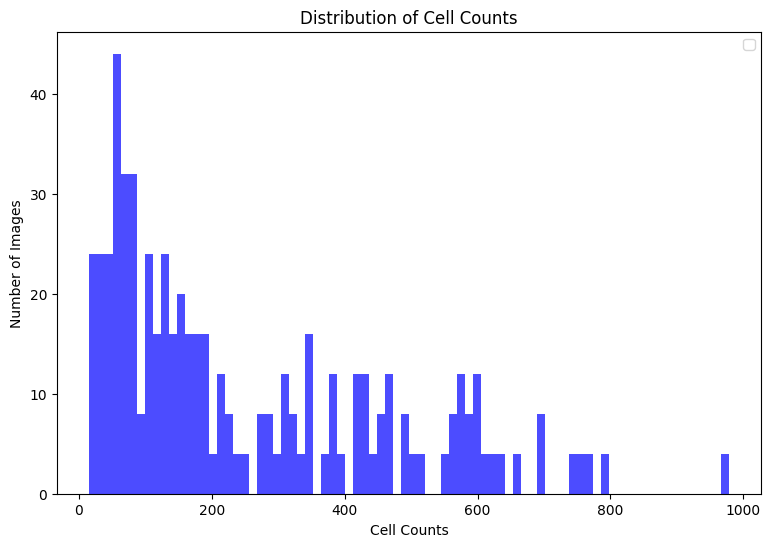

In [ ]:
# Create histograms
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
all_data = train_cell_counts + val_cell_counts + test_cell_counts


plt.hist(all_data, bins=80, density=False, alpha=0.7, color='blue')
#plt.hist(train_cell_counts, bins=60, density=False, alpha=0.7, color='red', label="Training")
#plt.hist(val_cell_counts, bins=60, density=False, alpha=0.7, color='orange', label="Validation")
#plt.hist(test_cell_counts, bins=60, density=False, alpha=0.7, color='green', label="Testing")
plt.title("Distribution of Cell Counts")
plt.xlabel("Cell Counts")
plt.ylabel("Number of Images")
plt.legend()


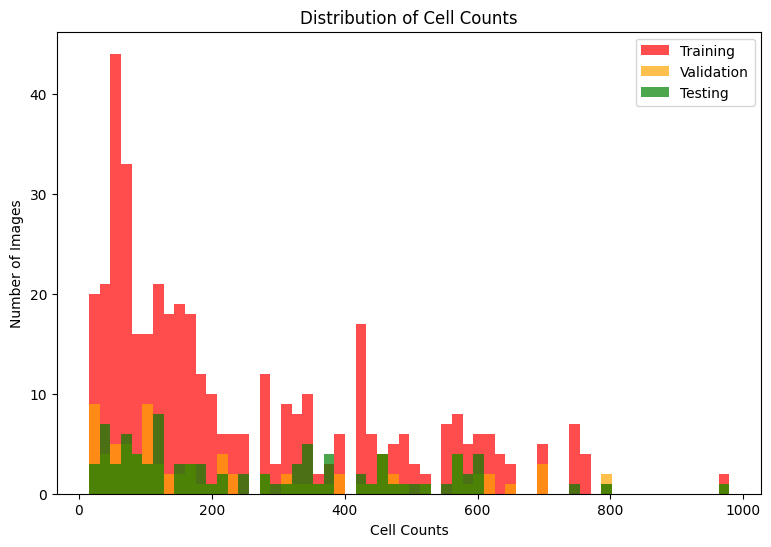

In [ ]:
# Create histograms
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

plt.hist(train_cell_counts, bins=60, density=False, alpha=0.7, color='red', label="Training")
plt.hist(val_cell_counts, bins=60, density=False, alpha=0.7, color='orange', label="Validation")
plt.hist(test_cell_counts, bins=60, density=False, alpha=0.7, color='green', label="Testing")
plt.title("Distribution of Cell Counts")
plt.xlabel("Cell Counts")
plt.ylabel("Number of Images")
plt.legend()

VGG16 Model

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class VGG16Regression(nn.Module):
    def __init__(self):
        super(VGG16Regression, self).__init__()
        # Load pre-trained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True).features

        # Freeze the pre-trained layers
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Custom layers for regression
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.vgg16(x)
        x = self.regressor(x)
        return x

# Instantiate the model
vgg16 = VGG16Regression()

loss_function = nn.MSELoss()
mae = nn.L1Loss()
optimizer = torch.optim.Adam(vgg16.regressor.parameters(), lr=0.001)



# def norm_mse(y_pred, y_true):
#     return torch.mean((((y_pred - y_true) ** 2)/y_pred))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# !pip install torchviz

In [ ]:
# from torchviz import make_dot

# vgg16 = VGG16Regression()
# x = torch.randn(1, 3, 224, 224)  # Example input tensor
# y = vgg16(x)
# dot = make_dot(y, params=dict(list(vgg16.named_parameters()) + [('x', x)]))
# dot.render('vgg16_graph', format='png')


'vgg16_graph.png'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Lists to store metrics
train_losses = []
train_maes = []
val_losses = []
val_maes = []

# Early stopping parameters
early_stopping_patience = 10
epochs_no_improve = 0
min_val_loss = float('inf')

num_epochs = 500

for epoch in range(num_epochs):
    # Training Phase
    vgg16.train()
    running_loss = 0.0
    running_mae = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_mae += mae(outputs, targets).item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_mae = running_mae / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_maes.append(train_mae)

    # Validation Phase
    vgg16.eval()
    val_running_loss = 0.0
    val_running_mae = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1)

            outputs = vgg16(inputs)
            loss = loss_function(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            val_running_mae += mae(outputs, targets).item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_mae = val_running_mae / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_maes.append(val_mae)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {train_loss:.4f} - '
          f'MAE: {train_mae:.4f} - '
          f'Val_Loss: {val_loss:.4f} - '
          f'Val_MAE: {val_mae:.4f}')

   # Early stopping check
    if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print(f'Early stopping triggered after {epoch + 1} epochs!')
            break


Epoch [1/500], Loss: 90413.2476 - MAE: 217.9236 - Val_Loss: 88444.6842 - Val_MAE: 204.3996
Epoch [2/500], Loss: 56657.1788 - MAE: 163.8053 - Val_Loss: 54972.8139 - Val_MAE: 178.4682
Epoch [3/500], Loss: 39737.0299 - MAE: 161.8541 - Val_Loss: 43524.4237 - Val_MAE: 177.2921
Epoch [4/500], Loss: 34149.6382 - MAE: 156.6820 - Val_Loss: 36458.6223 - Val_MAE: 158.7763
Epoch [5/500], Loss: 27754.7735 - MAE: 140.3348 - Val_Loss: 30236.5950 - Val_MAE: 143.1813
Epoch [6/500], Loss: 22267.8850 - MAE: 124.2201 - Val_Loss: 24714.3708 - Val_MAE: 126.0399
Epoch [7/500], Loss: 17965.9636 - MAE: 106.5993 - Val_Loss: 20667.7439 - Val_MAE: 109.2801
Epoch [8/500], Loss: 14528.3568 - MAE: 91.1774 - Val_Loss: 16950.3143 - Val_MAE: 97.3336
Epoch [9/500], Loss: 11806.6155 - MAE: 81.1806 - Val_Loss: 14142.4889 - Val_MAE: 86.7889
Epoch [10/500], Loss: 9837.9553 - MAE: 70.3741 - Val_Loss: 12134.9664 - Val_MAE: 76.9192
Epoch [11/500], Loss: 8447.9977 - MAE: 62.3358 - Val_Loss: 10841.8544 - Val_MAE: 70.8505
Epoch [

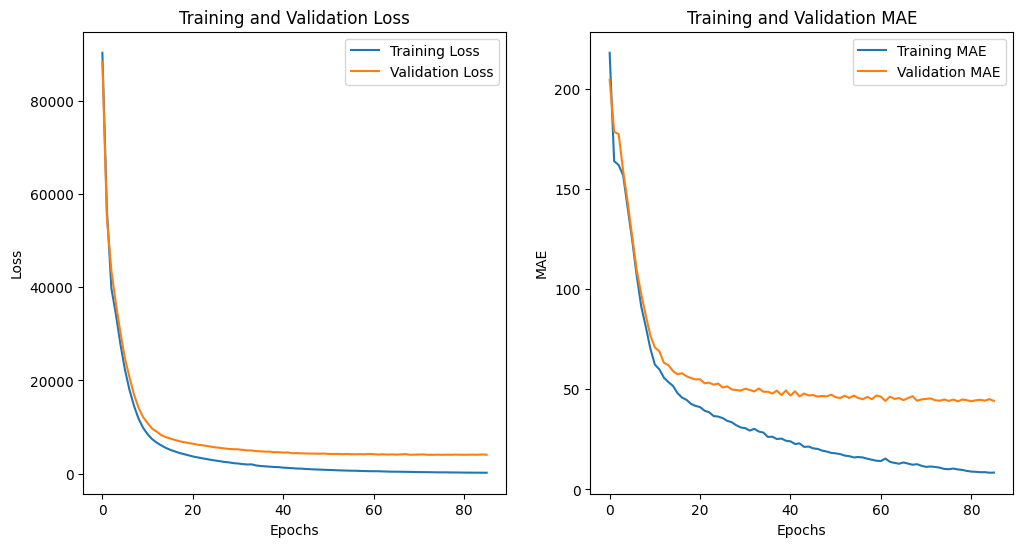

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MAE
plt.subplot(1, 2, 2)
plt.plot(train_maes, label='Training MAE')
plt.plot(val_maes, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

In [ ]:

vgg16.eval()

# Initialize metrics
test_loss = 0.0
test_mae = 0.0

# No gradient updates needed
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.float().unsqueeze(1)

        # Forward pass
        outputs = vgg16(inputs)
        loss = loss_function(outputs, targets)

        # Update metrics
        test_loss += loss.item() * inputs.size(0)
        test_mae += mae(outputs, targets).item() * inputs.size(0)

# Calculate average loss and MAE
test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Test Loss: 5564.8677, Test MAE: 47.5053


In [ ]:
def calculate_acp(model, test_loader, device, threshold=0.05):
    model.eval()
    acp_counter = 0
    total_images = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.float().unsqueeze(1)
            outputs = model(inputs)
            absolute_diff = torch.abs(outputs - targets)
            within_threshold = absolute_diff <= (threshold * targets)

            acp_counter += torch.sum(within_threshold).item()
            total_images += targets.size(0)


    acp = acp_counter / total_images
    return acp

# Calculate ACP
acp = calculate_acp(vgg16, test_loader, device)
print(f"Accuracy within 5%: {acp * 100}%")

Accuracy within 5%: 23.333333333333332%


The test on the new testset


In [ ]:
# # path for your new test images
# new_test_image = '/content/images'

# # Get the list of image file paths
# new_test_image_filenames = []
# for filename in os.listdir(new_test_image):
#     if filename.endswith('.tiff'):
#         new_test_image_filenames.append(filename)

# print(new_test_image_filenames)


['220909_GFP-AHPC_C_Ki67_F8_DAPI_ND1_20x.tiff', '220909_GFP-AHPC_D_MAP2ab_F9_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_A_Nestin_F10_DAPI_ND1_20x.tiff', '220909_GFP-AHPC_B_Ki67_F8_DAPI_ND1_20x.tiff', '220912_GFP-AHPC_A_Nestin_F9_DAPI_ND1_20x.tiff', '220912_GFP-AHPC_A_Map2AB_F1_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_B_GFAP_F5_DAPI_ND1_20x.tiff', '220912_GFP-AHPC_A_Nestin_F8_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_D_TuJ1_F9_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_A_Ki67_F8_DAPI_ND1_20x.tiff', '220909_GFP-AHPC_A_GFAP_F6_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_B_Nestin_F10_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_B_Nestin_F1_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_D_GFAP_F9_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_C_TuJ1_F4_DAPI_ND1_20x.tiff', '220816_GFP-AHPC_D_RIP_F3_DAPI_ND1_20x.tiff', '220816_GFP-AHPC_B_RIP_F7_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_C_TuJ1_F3_DAPI_ND1_20x.tiff', '220815_GFP-AHPC_A_Nestin_F7_DAPI_ND1_20x.tiff', '220912_GFP-AHPC_B_Nestin_F10_DAPI_ND1_20x.tiff', '220912_GFP-AHPC_A_TuJ1_F3_DAPI_ND1_20x.

In [ ]:
import torch
from torchvision import models
from torch.utils.data import DataLoader

vgg16.eval()

new_test_image_path = '/content/images'
image_paths = [os.path.join(new_test_image_path, filename) for filename in os.listdir(new_test_image_path) if filename.endswith('.tiff')]


# print (image_paths)

In [ ]:
from torchvision.transforms import ToTensor, Resize, Grayscale

class NewTestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image, image_path

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Instantiate the dataset and dataloader
new_test_dataset = NewTestDataset(image_paths, transform=transform)
new_test_dataloader = DataLoader(new_test_dataset, batch_size=1, shuffle=False)

# Predict the number of cells
for image, image_path in new_test_dataloader:
    image = image.to(device)
    output = vgg16(image)
    predicted_count = int(output.data)

    # Print or store the image name with its predicted count
    print(f"{os.path.basename(image_path[0])}: {predicted_count}")


220909_GFP-AHPC_C_Ki67_F8_DAPI_ND1_20x.tiff: 119
220909_GFP-AHPC_D_MAP2ab_F9_DAPI_ND1_20x.tiff: 316
220815_GFP-AHPC_A_Nestin_F10_DAPI_ND1_20x.tiff: 388
220909_GFP-AHPC_B_Ki67_F8_DAPI_ND1_20x.tiff: 45
220912_GFP-AHPC_A_Nestin_F9_DAPI_ND1_20x.tiff: 204
220912_GFP-AHPC_A_Map2AB_F1_DAPI_ND1_20x.tiff: 71
220815_GFP-AHPC_B_GFAP_F5_DAPI_ND1_20x.tiff: 743
220912_GFP-AHPC_A_Nestin_F8_DAPI_ND1_20x.tiff: 111
220815_GFP-AHPC_D_TuJ1_F9_DAPI_ND1_20x.tiff: 57
220815_GFP-AHPC_A_Ki67_F8_DAPI_ND1_20x.tiff: 25
220909_GFP-AHPC_A_GFAP_F6_DAPI_ND1_20x.tiff: 433
220815_GFP-AHPC_B_Nestin_F10_DAPI_ND1_20x.tiff: 146
220815_GFP-AHPC_B_Nestin_F1_DAPI_ND1_20x.tiff: 324
220815_GFP-AHPC_D_GFAP_F9_DAPI_ND1_20x.tiff: 224
220815_GFP-AHPC_C_TuJ1_F4_DAPI_ND1_20x.tiff: 54
220816_GFP-AHPC_D_RIP_F3_DAPI_ND1_20x.tiff: 54
220816_GFP-AHPC_B_RIP_F7_DAPI_ND1_20x.tiff: 401
220815_GFP-AHPC_C_TuJ1_F3_DAPI_ND1_20x.tiff: 23
220815_GFP-AHPC_A_Nestin_F7_DAPI_ND1_20x.tiff: 126
220912_GFP-AHPC_B_Nestin_F10_DAPI_ND1_20x.tiff: 36
220912_GF

In [ ]:
import csv

existing_data = {}
with open('submission.csv', mode='r') as infile:
    reader = csv.reader(infile)
    header = next(reader)
    for rows in reader:
        existing_data[rows[0]] = rows[1]


for image, image_path in new_test_dataloader:
    image = image.to(device)
    output = vgg16(image)
    predicted_count = int(output.data)

    image_name = os.path.basename(image_path[0])
    if image_name in existing_data:
        existing_data[image_name] = predicted_count


with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    for image_name, count in existing_data.items():
        writer.writerow([image_name, count])
